# Classification: $H \rightarrow ZZ \rightarrow 4\ell$<br>
 >__Created__:  2018 Harrison B. Prosper<br>
 >__Updated__: May 2022 INFN School of Statistics, Paestum, Italy
 
 
## Introduction
In this notebook, we build a machine learning model (a simple neural network) to discriminate between two classes of events, $H \rightarrow ZZ \rightarrow 4\ell$ produced via vector-boson fusion (__vbf__) and the same final state produced via gluon-gluon fusion (__ggF__). We use __supervised learning__ in which the data instances $x$ that characterize the objects to be classified, here Higgs boson events,  are unambiguously labeled by the class to which the instances belong. The class labels $y$ are referred to as __targets__. We shall use $y = 0$ for ggf events and $y = 1$ for vbf events.

The data are read from __csv__ files, each row of which contains quantities that characterize $H \rightarrow ZZ \rightarrow 4\ell$ events. In __machine learning__, these quantities are often referred to as __features__ and form __feature vectors__. We use the following features $\boldsymbol{x} \equiv (|\Delta\eta_{jj}|, m_{jj})$ where $|\Delta\eta_{jj}|$ is the di-jet absolute pseudorapidiy difference (detajj) and $m_{jj}$ the di-jet mass (massjj). 
 
The fundamental assumption of almost all machine learning models is that the data are sampled from a  (typically, unknown) joint probability distribution $p(t, \mathbf{x}) dt d\mathbf{x}$. 

We shall use the model 

$$f(\boldsymbol{x}, \boldsymbol{\omega}) = \text{sigmoid}(\, b_3 + \boldsymbol{w}_3\text{relu}(\, \boldsymbol{b}_2 + \boldsymbol{w}_2 \, \text{relu}(\,\boldsymbol{b}_1 + \boldsymbol{w}_1 \, \text{relu}(\boldsymbol{b}_0 + \boldsymbol{w}_0 \, \boldsymbol{x}) \, )\,)\,),$$

where $\boldsymbol{b}$ and $\boldsymbol{w}$ (the biases and weights) are the parameters $\boldsymbol{\omega}$ of the model and $\mbox{relu}(x)$ is a non-linear function defined by
\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise} ,
\end{cases}
\end{align*}
applied to every element $x_i$ of its argument (i.e., applied element-wise). 

The functions $\mbox{sigmoid}(x)$ and $\mbox{relu}(x)$ are implemented in the PyTorch functions
torch.sigmoid(...) and torch.relu(...), respectively. In this exercise, $b_3$ is a scalar since we have just one output. 


## Bayes' Theorem

As we shall see later, a classifier approximates a conditional probability. Therefore, as background, we give a brief sketch of Bayes' theorem.

Let
\begin{align}
    p(A) & = \textrm{Probability of } A,\\
    p(B) & = \textrm{Probability of } B,\\
    \textrm{and } p(AB) = p(A \cap B ) & = \textrm{Probability of } A \textrm{ and } B,
\end{align}
then,
\begin{align}
    p(A | B) & = \frac{p(AB)}{p(B)},
\end{align}
is called the *conditional probability* of $A$ given $B$. This probability answers the following question: what is the chance that $A$ is true given that $B$ is true. For example, let $B = \text{it is a cat}$ and let $A = \text{the fur is white}$, then $p(A | B)$ is the probability that the fur is white given that it is a cat.

From the definition of conditional probability, it follows that
$p(AB) = p(A | B) \, p(B)$. But, by swapping $A$ and $B$ on both sides of that equation, it is also true that $p(BA) = p(B | A) \, p(A)$. But, since $p(AB) = p(BA)$, this leads to 
\begin{align}
    p(\color{red}{B} | A ) & = \frac{p(A | \color{red}{B}) \, p(\color{red}{B})}{p(A)},
\end{align}
which is __Bayes' Theorem__ (Thomas Bayes, 1763).

Suppose we have multiple $B$s, $B_k$, $k = 1, \cdots$ and the set of $B$s is *exhaustive*, that is, it contains all possible (relevant) $B_k$, then Bayes' theorem becomes
\begin{align}
    p(B_k | A ) & = \frac{p(A | B_k) \, p(B_k)}{p(A)}.
\end{align}
Because the set of $B_k$ is *exhaustive*, it follows that 
\begin{align}
    \sum_k p(B_k | A ) & = 1.
\end{align}

Consequently, $p(A)$ must satisfy the sum rule
\begin{align}
        p(A) & = \sum_k p(A | B_k) \, p(B_k), \\
            & = \sum_k p(A B_k) .
\end{align}


## Loss function
Typically, a machine learning model is fitted to the __training data__ by minimizing a suitably defined function, which in the statistics literature is referred to as the __empirical risk__. (Fitting models to data is called __learning__, hence machine learning.) The empirical risk,
\begin{align}
    R_E &= \frac{1}{n} \sum_{i=1}^n L(t_i, \, f(\boldsymbol{x}_i, \boldsymbol{\omega})),
\end{align}
is a Monte Carlo approximation of the __risk functional__ 
\begin{align}
    R[f] &= \int \int L(t, \, f(\boldsymbol{x}, \boldsymbol{\omega})) \, 
    p(t, \, \boldsymbol{x}) \, dt \, d\boldsymbol{x},
\end{align}
where $L(t, \, f)$ is called the __loss function__ and measures how much one loses if the output of the parameterized function $f(\boldsymbol{x}, \boldsymbol{\theta})$ differs from the __target__ $t$. $\color{blue}{\rm Warning}$: In the machine learning world, the empirical risk is typicaly referred to as the loss function, when what is really meant is the *average* loss function, that is, the empirical risk.

### Minimizing the empirical risk (aka average loss)
The purpose of a minimization algorithm, such as __stochastic gradient descent__, is to approximate the equation

$$\frac{\delta R}{\delta f} = 0, \quad \forall \, \, \boldsymbol{x}$$

and thereby approximate its solution $f^*$. But in order for the risk functional $R[f]$ to reach its minimum, where $\delta R = 0$ $\forall \, \, \boldsymbol{x}$, the model $f$ must have sufficient __capacity__, that is, it must be capable, in principle, to model mathematical quantities that are close to the true, unknown, quantity $f^*$. Moreover, if the latter condition is satisfied, then the mathematical quantity $f^*$ depends solely on the form of the loss function $L(t, \, f)$ and the probability distribution $p(t, \, \boldsymbol{x}) dt d\boldsymbol{x}$ from which the training data are presumed to have been sampled. In particular, the mathematical quantity approximated by $f^*$ does not depend on
    the details of the model $f$ apart from its capacity, which we presume to be sufficient. 
    
  Of course, in practice, we do not minimize $R[f]$, but rather the empirical risk, $R_E$, which approximates it. Nevertheless, this bit of reasoning suggests that it is as least as important to think about the form of the loss function $L(t, \, f)$ as it is to think about the form of the model. If we have two models of equal capacity then, *a priori*, for the same loss function the models will approximate the same mathematical quantity. While the mathematical quantity approximated does not depend on the details of the model, the *quality* of the approximation, however, does.


### Required modules

In [2]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard scientific computing module
#import scipy as sp
#import scipy.stats as st
#import scipy.optimize as op

# a truly outstanding symbolic algebra module
#import sympy as sm
#sm.init_printing()

# standard module to serialize, that is, save, objects
import joblib as jb

# machine learning toolkit developed by FaceBook
import torch
import torch.nn as nn
#from torch.utils.data import Dataset

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# linearly transform a feature to zero mean and unit variance
from sklearn.preprocessing import StandardScaler

# standard measures of model performance
from sklearn.metrics import roc_curve, auc

# to reload modules
import importlib

In [3]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load Higgs boson data into memory

  * Z1mass: mass, $m_{Z_1}$, of Z boson with mass closest to 90 GeV
  * Z2mass: mass, $m_{Z_2}$, of second Z boson
  * pt4l: transverse momentum, $p_{T 4\ell}$ of 4-lepton system
  * eta4l: pseudo-rapidity, $\eta_{4\ell}$, of 4-lepton system
  * massjj: di-jet mass, $m_{jj}$
  * detajj: absolute value of di-jet pseudo-rapidity difference, $|\Delta\eta|_{jj}$
  * HT: scalar sum of jet transverse momenta, $H_T$
  * dRZ1Z2: $\delta R$ $( = \sqrt{\Delta\eta^2 + \Delta\phi^2})$ between the Z bosons
  * target: 1 for VBF events, 0 for ggF events

In [4]:
train_data = pd.read_csv('../datasets/hzz_vbf_ggf_train.csv') 
test_data  = pd.read_csv('../datasets/hzz_vbf_ggf_test.csv')
print('training data set size: %5d' % len(train_data))
print('testing data set size:  %5d' % len(test_data))
train_data[:5]

training data set size: 50000
testing data set size:  10000


,Z1mass,Z2mass,pt4l,eta4l,massjj,detajj,HT,dRZ1Z2,target
0,90.29,14.06,215.80,-0.1829,86.08,0.3362,324.5,0.4905,0.0
1,86.57,37.24,217.80,0.3579,310.20,2.8900,219.9,0.1691,0.0
2,97.37,13.46,138.90,-0.8100,220.40,2.9030,106.3,0.4296,0.0
3,91.96,18.97,54.89,-2.6840,583.50,5.0130,101.6,1.7580,1.0
4,91.45,12.06,187.80,-0.5866,55.98,0.3771,220.2,0.6852,1.0


### Specify features to be used for the classifier.

In [7]:
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

XBINS =   8
XMIN  =   0
XMAX  =   8
XSTEP =   2

YBINS =  10
YMIN  =   0
YMAX  =2000
YSTEP = 400

features = [XNAME, YNAME]
target   = 'target'

In [8]:
# split into signal and background events
sig = train_data[train_data['target'] > 0]
bkg = train_data[train_data['target'] < 1]

s, xedges, yedges = np.histogram2d(sig[XNAME], sig[YNAME], 
                                   bins=(XBINS, YBINS), 
                          range=((XMIN, XMAX), (YMIN, YMAX)))

b, xedges, yedges = np.histogram2d(bkg[XNAME], bkg[YNAME], 
                                   bins=(XBINS, YBINS), 
                          range=((XMIN, XMAX), (YMIN, YMAX)))

x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2
x, y = np.meshgrid(x, y)

# WARNING: must transpose z so that x, y, and z have the
# same shape
d = np.where(s + b <= 0, 1e10, s + b)
z = s / d
H = (x, y, z.T)

K = 10000
t = test_data[:K]
sig = t[t['target'] > 0]
bkg = t[t['target'] < 1]
print(len(sig), len(bkg), len(sig)+len(bkg))

5000 5000 10000


### Plot data

Note: __matplotlib__ has two graphics systems: 1) function-based and 2) object-based. The function below illustrates the function-based system.

In [34]:
def plot_data(vbf, ggf, H=None, 
              filename='higgs_vbf_ggf_variables.png',
              xmin=XMIN, xmax=XMAX, xstep=XSTEP, 
              xname=XNAME, xlabel=XLABEL,
              ymin=YMIN, ymax=YMAX, ystep=YSTEP,
              yname=YNAME, ylabel=YLABEL,
              N=1000, 
              ftsize=FONTSIZE):
    
    # set size of figure
    fig = plt.figure(figsize=(5, 5))

    # set axes' limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(xlabel, fontsize=ftsize)
    plt.xticks(np.arange(xmin, xmax+xstep, xstep))
    
    plt.ylabel(ylabel, fontsize=ftsize)
    plt.yticks(np.arange(ymin, ymax+ystep, ystep))

    plt.scatter(vbf.detajj, vbf.massjj, marker='o',
                s=30, c='blue', alpha=0.3, label='VBF')
    plt.legend(loc='upper left') # activate legend
    
    plt.scatter(ggf.detajj, ggf.massjj, marker='*',
                s=80, c='red',  alpha=0.4, label='ggF')
    plt.legend(loc='upper left') # activate legend
    
    if H:
        X, Y, Z = H
        mylevels = np.arange(0.1, 1, 0.1)
        cs = plt.contour(X, Y, Z, levels=mylevels, cmap='rainbow_r')
        plt.clabel(cs, cs.levels, inline=True, 
              fontsize=18, fmt='%4.2f', 
              colors='black')
    
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

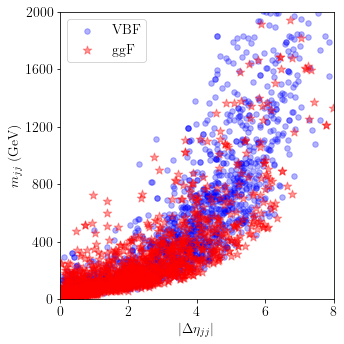

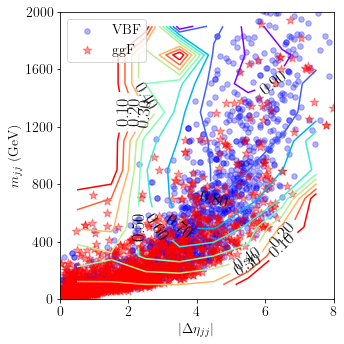

In [36]:
N = 1500
plot_data(sig[:N], bkg[:N], 
          filename='higgs_vbf_ggf_data.png')

plot_data(sig[:N], bkg[:N], H=H,
          filename='higgs_vbf_ggf_data_based_contours.png')

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of the fitted model.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

### Prepare data
  1. Split training data into two parts: one for fitting and one for validation.
  1. Apply a linear transformation to data so that each feature has zero mean, unit variance.

In [13]:
# Split the training data into a part for fitting and
# a part for validation during training.
fraction = 1/10
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes (and drop the old ones)
# so that the indices start from zero and increment by one
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5][features]

train set size:         45000
validation set size:     5000
test set size:          10000


,detajj,massjj
0,6.3170,2220.00
1,0.8105,40.40
2,3.8980,364.10
3,0.3362,25.63
4,3.6620,266.90


Transform data and split data into targets $t$ and inputs $\mathbf{x}$

In [14]:
# create object to transform source (i.e., input) data 
scaler  = StandardScaler()
scaler.fit(train_data[features])

def split_t_x(df, target, source, scaler):
    # change from pandas dataframe format to a numpy array
    t = np.array(df[target])
    x = np.array(scaler.transform(df[source]))
    return (t, x)

train_t, train_x = split_t_x(train_data, target, features, scaler)
valid_t, valid_x = split_t_x(valid_data, target, features, scaler)
test_t,  test_x  = split_t_x(test_data,  target, features, scaler)
train_t[:5], train_x[:5]

(array([1., 0., 0., 0., 0.]),
 array([[ 1.77812586,  3.48405486],
        [-1.11490054, -0.77383823],
        [ 0.50722223, -0.14148367],
        [-1.36409012, -0.80269173],
        [ 0.38323163, -0.33136586]]))

### Return a (random) batch of data from the training set

In [15]:
def randomBatch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "number" integers from 
    # the range [0, length-1] 
    rows    = rnd.choice(len(x), batch_size)
    # pick out rows defined by the integers in array "rows"
    batch_x = x[rows]
    batch_t = t[rows]
    return batch_x, batch_t

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined by

\begin{align}
R_E(\theta) & = \frac{1}{n}\sum_{i=1}^n L(t_i, f_i),
\end{align}

where 

\begin{align*}
    f_i & \equiv f(\boldsymbol{x}_i, \boldsymbol{\omega})
\end{align*}

is the model, with parameters $boldsymbol{\omega}$, to be fitted (i.e., trained).

As noted in the Introduction, the empirical risk $R_E$ approximates the __risk functional__

\begin{align}
R[f] & = \int \int \,  L(t, f) \, p(t, \boldsymbol{x}) \, dt \, d\boldsymbol{x} .
\end{align}

The quantity $p(t, \boldsymbol{x}) \, dt\, d\boldsymbol{x}$ is the probability distribution from which the sample $\{ (t_i, \boldsymbol{x}_i), i = 1,\cdots, n \}$ is presumed drawn. 

### Empirical risk minimization (aka, minimizing the average loss)
Noting that $p(t | \boldsymbol{x}) = p(t, \boldsymbol{x}) / p(\boldsymbol{x})$ provided that $p(\boldsymbol{x}) > 0, \,\, \forall \,\, \boldsymbol{x}$, we can rewrite $R[f]$ as
\begin{align}
R[f] & = \int d\boldsymbol{x} \left[\int \, L(t, f) \, p(t | \boldsymbol{x}) \, dt \right].
\end{align}
If the model $f$ has sufficient capacity, then it will be possible to set
\begin{align}
    \frac{\delta R}{\delta f} & = 0, \quad \forall \, \, \boldsymbol{x},
\end{align}
and arrive at the equation

$$\boxed{\,\,
\int \, \frac{\partial L(t, f)}{\partial f} \, p(t | \boldsymbol{x}) \, dt = 0}.$$

This is an important equation because it determines the mathematical quantity that is being approximated by the fitted model, $\hat{f}(x) \equiv f(\boldsymbol{x}, \hat{\boldsymbol{\omega}})$. Moreover, this equation confirms that the quantity approximated by the model is independent of its details. It does not matter whether the model is a lowly fully-connected neural network, such as the one in this tutorial, or a state-of-the-art transformer network. If both are trained with the same data and the same loss function both will approximate the same quantity. The difference is that the state-of-the-art model will yield an approximation that is superior to the one provided by the lowly model.

The necessary and sufficient conditions for arriving at this conclusion is that 1) $f$ has sufficient __capacity__, 2) the fit has been made with sufficient data, and 3) the minimizer is able to find a good approximation to the global minimum of the average loss.


#### Quadratic loss
For the __quadratic loss__ $L(t, f) = (t - f)^2$, solving the above equation yields 

$$ f^* = \int t \, p(t | \boldsymbol{x} ) \, dt ,$$

that is, we conclude that the solution $f^*$ is the mean of the conditional probability $p(t | \boldsymbol{x} ) \, dt$. If the targets are discrete, for example, $t \in \{0, 1\}$, then

\begin{align}
    f^* & = p(t=1| \boldsymbol{x}) = \frac{p(\boldsymbol{x}|t=1) p(t=1)}
    {p(\boldsymbol{x}|t=1) p(t=1)+ p(\boldsymbol{x}|t=0) p(t=0)},
\end{align}

that is, $f^*$ is equal to the probability that an object belongs to the class labeled by $t = 1$ given that the object is characterized by the feature vector $\boldsymbol{x}$, where $p(t=1) \, / \, p(t=0)$ are the relative proportions of the two classes of objects in the sample used to fit the model $f$.


The quadratic loss is typically used in regression problems, but as noted above, it can also be used to construct classifiers. However, because of its sensitivity to outliers it is more common to use the cross-entropy loss for classification problems.


#### Binary cross-entropy loss
The binary (i.e., 2-class) cross-entropy loss is defined by 

$$L(t, f) = - [t \log f + (1 - t) \log(1-f)],$$ 

with the discrete targets $t \in \{0, 1\}$. From

\begin{align*}
0 & = \int \, \frac{\partial L(t, f)}{\partial f} \, p(t | \boldsymbol{x}) \, dt, \quad \text{ we see that}\\
    & = \int \,  \left( \frac{t}{f} - \frac{(1 - t)}{1-f}  \right) p(t | \boldsymbol{x}) \, dt,\\
    & = \frac{p(t=1 | \boldsymbol{x})}{f} - \frac{p(t=0 | \boldsymbol{x})}{1 -f},\\
   \frac{f}{1-f} & = \frac{p(t=1 | \boldsymbol{x})}{p(t=0 | \boldsymbol{x})},\quad \implies f  = p(t=1 | \boldsymbol{x}) .
\end{align*}

Again, we stress that this conclusion is independent of the details of the model $f(\boldsymbol{x}, \boldsymbol{\omega})$.

In [16]:
# Note: there are several average loss functions available 
# in PyTorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t):
    # f and t must be of the same shape
    avloss = torch.mean((f - t)**2)
    return avloss

def average_cross_entropy(f, t):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

This function is used to validate the model while it is being fitted.

In [17]:
def validate(model, avloss, inputs, targets):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # reshape to ensure that y and t are of the same shape!
        y = model(x).reshape(t.shape)
    return avloss(y, t)

### Function to execute training loop

In [18]:
def train(model, optimizer, avloss, getbatch, modelfile,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'training', 'validation'))
    
    min_acc_v = 1e30
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = randomBatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: y is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with y and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        y = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss.
        # adding a bit of noise helps the minimizer escape
        # from minima that may not optimal. it is also much
        # faster to compute the loss function and its gradient
        # with respect to its parameters using a batch of 
        # training data rather than the full training dataset.
        empirical_risk = avloss(y, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            if acc_v < min_acc_v:
                min_acc_v = acc_v
                torch.save(model.state_dict(), modelfile)

    print()      
    return xx, yy_t, yy_v

In [19]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

### Define model $f(\mathbf{x}, \theta)$

In [20]:
%%writefile hzzdnn.py

import torch
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, n_inputs=2, n_nodes=50, n_layers=2):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y


Overwriting hzzdnn.py


### Train!

Instantiate a model, an optimizer, then train

In [21]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
# load model
import hzzdnn
importlib.reload(hzzdnn)
model = hzzdnn.Model()
print(model)
print('number of parameters: %d' % number_of_parameters(model))

modelfile   = 'hzzdnn.dict'
traces_step = 10
traces      = ([], [], [])

Model(
  (layer0): Linear(in_features=2, out_features=50, bias=True)
  (layer1): Linear(in_features=50, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=1, bias=True)
)
number of parameters: 2751


In [23]:
n_iterations  = 80000
n_batch       =    50

learning_rate = 1.e-3
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

average_loss  = average_cross_entropy

traces = train(model, optimizer, average_loss, 
               randomBatch, modelfile,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

 iteration	  training	validation
         0	  0.687057	  0.686900
     79990	  0.586022	  0.579666


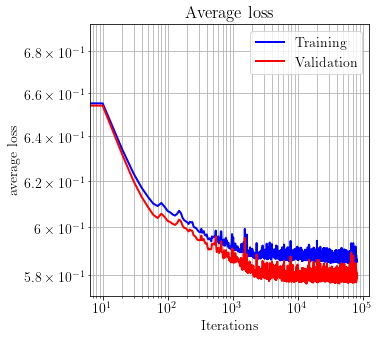

In [24]:
plot_average_loss(traces)

In [25]:
# if use_saved_model = False, use current parameters of trained model,
# otherwise use model with smallest average loss computed using
# validation data.
use_saved_model = False
if use_saved_model:
    model.load_state_dict(torch.load(modelfile))

### Plot distribution of model output 

In [26]:
def compute(model, x):
    # convert numpy ndarray to a pytorch tensor
    x = torch.Tensor(x)
    # go to evaluation mode
    model.eval()
    # compute,reshape to a 1-d array, and convert to a numoy array
    y = model(x).view(-1,).detach().numpy()
    return y

test_y = compute(model, test_x)

In [27]:
def plot_distribution(y, t, 
                      nbins=50, 
                      ftsize=FONTSIZE, 
                      fgsize=(5, 5)):

    # select the model output results for VBF events
    vbf = y[t > 0.5]
    
    # select the model output results for ggF events
    ggf = y[t < 0.5]
    
    # set size of figure
    plt.figure(figsize=fgsize)
    
    plt.xlim(0, 1)
    plt.ylim(0, 4)
    
    plt.hist(ggf, 
             bins=nbins, 
             color=(1,0,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (ggF)') 
    plt.legend(fontsize='small')
    
    plt.hist(vbf, 
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (VBF)')
    plt.legend(fontsize='small')

    plt.savefig("hzz_distributions.png")
    plt.show()

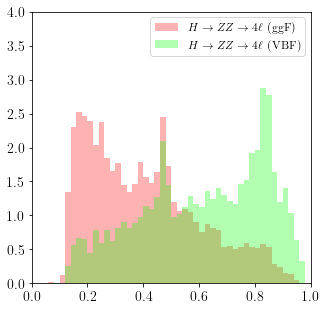

In [28]:
plot_distribution(test_y, test_t)

### Plot Receiver Operating Characteristic (ROC) curve
The ROC curve was developed in the context of radar operations during World War II. It is a simple measure of the performance of a binary classifier. Recall the definition of the __right cumulative distribution function__

$$D_R(y) = \mathbb{P}(y > y_0).$$

When applied to the histograms above, $D_R(y)$ gives the fraction of events that remain when they are selected by applying the cut $y > y_0$ on the output $y$ of the classifier. The ROC curve is a plot of $D_R(y)$ for one class of objects versus $D_R(y)$ for the other class for different thresholds $y_0$. Another simple measure of performance, this time a global one, is the area under the ROC curve (AUC). 

If the histograms were identical the ROC curve would be a diagonal line of unit slope (see blue-dashed curve below) and the AOC would be 0.5. Borrowing some jargon from statistics, a classifier whose ROC curve dips below the diagonal line could justifiably be called *inadmissible*!

In [29]:
def plot_ROC(y, p):
    bad, good, _ = roc_curve(y, p)
    roc_auc = auc(bad, good)
    plt.figure(figsize=(5, 5))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('fraction of ggF events', fontsize=14)
    plt.ylabel('fraction of VBF events', fontsize=14)
    
    plt.plot(bad, good, color='red',
             lw=2, label='ROC curve, AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

    plt.legend(loc="lower right", fontsize=14)
    
    plt.savefig("hzz_ROC.png")
    plt.show()

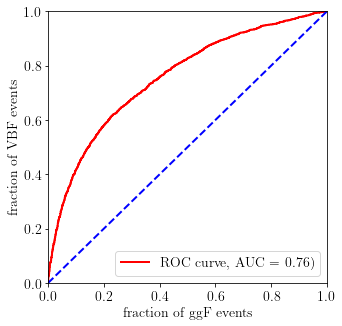

In [30]:
plot_ROC(test_t, test_y)

In [31]:
def compute_dnn_contours(dnn, scaler,                  
                 xmin=XMIN, xmax=XMAX, 
                 ymin=YMIN, ymax=YMAX):
    # 1. first create a mesh
    # 2. compute network output at all mesh points
    npoints= 100
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    xx     = np.arange(xmin, xmax, xdelta)
    yy     = np.arange(ymin, ymax, ydelta)
    X, Y   = np.meshgrid(xx, yy)
    
    # convert mesh to a dataframe
    XY     = pd.DataFrame({'detajj': X.flatten(), 
                           'massjj': Y.flatten()})
   
    # apply standardization to data
    XY = scaler.transform(XY)
    
    # compute model output at every grid point
    # then reshape to an (npoints x npoints) array
    Z = compute(dnn, XY).reshape([npoints, npoints])
    return (X, Y, Z)

In [32]:
dnn_H = compute_dnn_contours(model, scaler)

### Superimpose $p(t = 1| |\Delta\eta_{jj}|, m_{jj})$ on $(|\Delta\eta_{jj}|, m_{jj})$ distribution

As we explained in the section on empirical risk, the cross-entropy loss yields a model that approximates the probability $p(t = 1| \mathbf{x})$, which is displayed as contours of fixed probability.

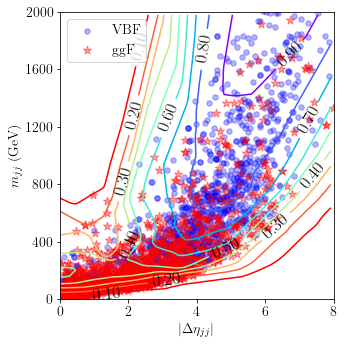

In [37]:
plot_data(sig[:N], bkg[:N], H=dnn_H, 
          filename='higgs_vbf_ggf_dnn_contours.png')